In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from i_forest import run_loso_CV,run_subject_specific_cv, run_train_test_split, plot_feature_importance, grid_search, plot_ranked_feature_selection, plot_pca_feature_selection
from thresholds import test_supervised_acc_threshold

In [2]:
features = pd.read_csv('features.csv')

In [ ]:
def print_results(auc_scores, threshold_scores, i=0):
    print(f'    AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}')
    print()
    for score in threshold_scores[i:]:
        print(score["func"] if isinstance(score["func"], str) else score["func"].__name__)
        print(f'    Acc: {np.mean(score["acc"]):.4f} ± {np.std(score["acc"]):.4f}')
        print(f'    Prec: {np.mean(score["prec"]):.4f} ± {np.std(score["prec"]):.4f}')
        print(f'    Rec: {np.mean(score["rec"]):.4f} ± {np.std(score["rec"]):.4f}')
        print(f'    Threshold: {np.mean(score["threshold"]):.4f} ± {np.std(score["threshold"]):.4f}')
        if score["func"] == test_supervised_acc_threshold:
            print(f'    Percentile: {np.mean(score["percentile"]):.4f} ± {np.std(score["percentile"]):.4f}')
        print()

def plot_histogram(scores_0, scores_1, legend_loc='upper left', y_lim_top=100, x_lim=None):
    range = (min(np.concatenate([scores_0, scores_1])), max(np.concatenate([scores_0, scores_1]))) if x_lim is None else x_lim

    plt.figure(figsize=(6,5))
    counts_0, bins_0, _ = plt.hist(scores_0, bins=80, alpha=0.5, range= range, label='Normal')
    counts_1, bins_1, _ = plt.hist(scores_1, bins=80, alpha=0.5, range= range, label='Anomaly')

    kde_0 = gaussian_kde(scores_0, bw_method=0.1)
    kde_1 = gaussian_kde(scores_1, bw_method=0.1)

    x_vals = np.linspace(range[0], range[1], 500)
    kde_0_vals = kde_0(x_vals) * max(counts_0) / max(kde_0(x_vals))
    kde_1_vals = kde_1(x_vals) * max(counts_1) / max(kde_1(x_vals))

    plt.plot(x_vals, kde_0_vals, color='tab:blue', linewidth=2)
    plt.plot(x_vals, kde_1_vals, color='tab:orange', linewidth=2)

    plt.axvline(x=0, color='black', linestyle='--', label='Threshold')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.ylim(top=y_lim_top)
    plt.xlim(x_lim)
    plt.legend(loc=legend_loc)
    plt.show()


# Experiment 1: Cross-Subject Modeling
The Isolation Forest model was trained on data from multiple subjects and evaluated on data from a subject that was not included in the training set

In [4]:
param_grid = {
        'bootstrap': [False],
        'contamination': [0.5, 0.48, 0.45, 0.4, 0.3, 0.2],
        'max_features': [0.2, 0.5, 0.8, 0.9, 1.0],
        'max_samples': [0.005, 0.01, 0.03, 0.05],
        'n_estimators': [30, 50, 80, 100, 150, 200, 250],
        }

# grid_search(features, param_grid)

# Isolation Forest parameters
params = {'bootstrap': False, 'contamination': 'auto', 'max_features': 1.0, 'max_samples': 0.01, 'n_estimators': 50}

## Feature Selection/ Dimensionality Reduction
### 1. PCA

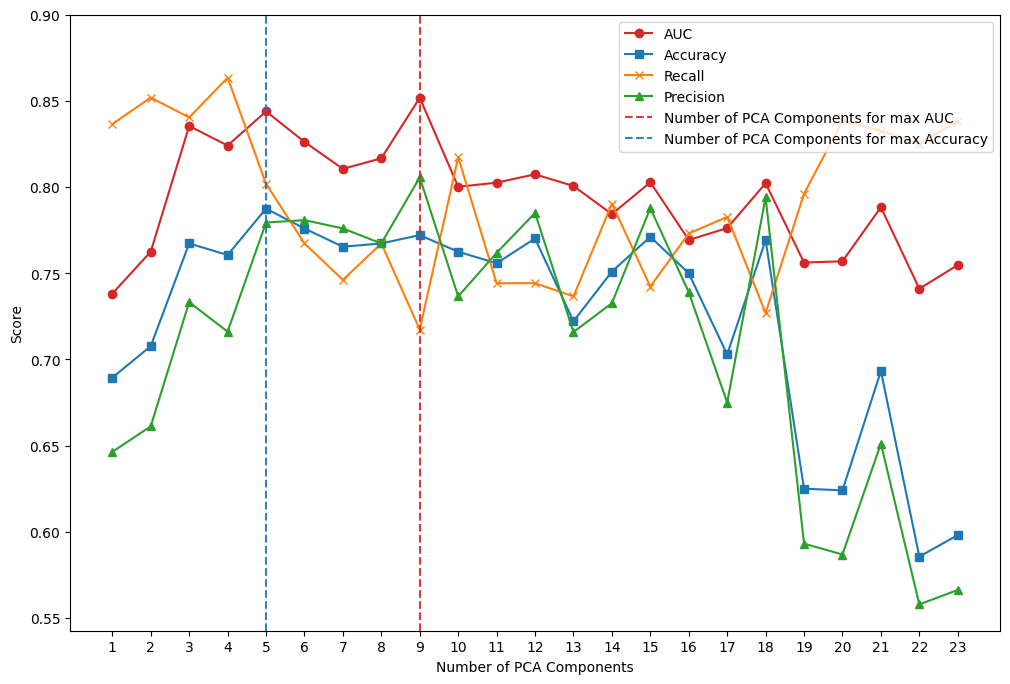

Max AUC: 0.8518361686390533
Max Accuracy: 0.7875


In [8]:
plot_pca_feature_selection(features=features[[col for col in features.columns if col.startswith('eda')] + ['subject_id', 'class']], params=params, components=range(1, 24))

### 2. Rank features using Isolation Forest

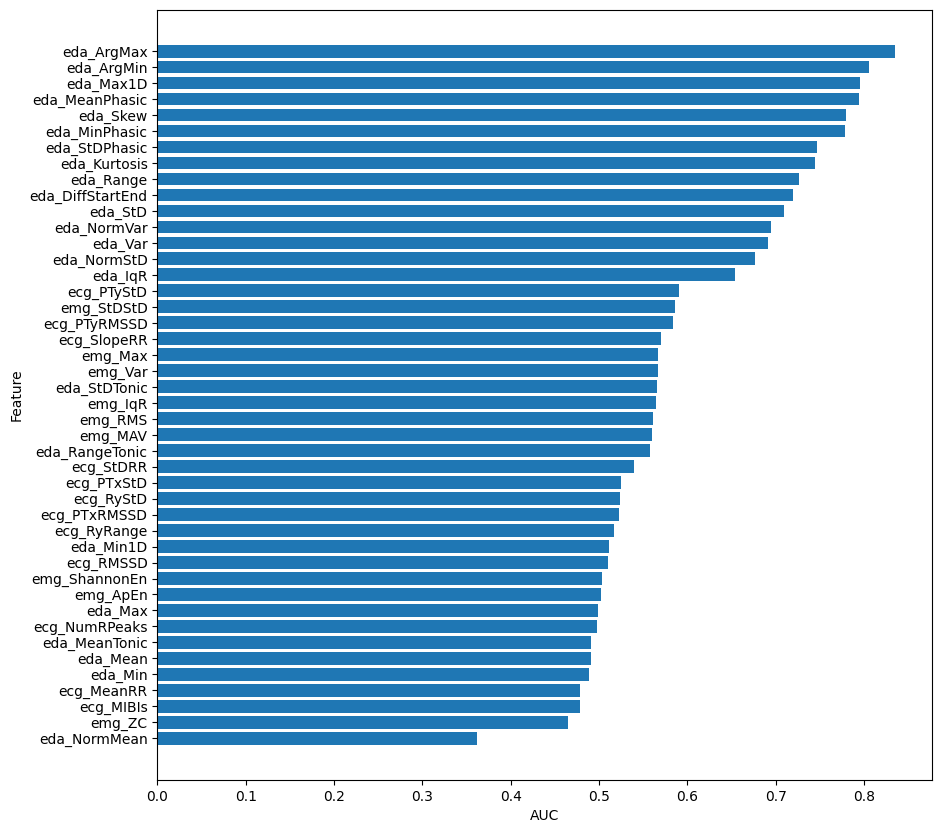

In [5]:
aucs = []
for feature in features.columns[:-2]:
    auc = run_train_test_split(features[[feature, 'class', 'subject_id']], params)['auc']
    aucs.append(auc)

plot_feature_importance(features, aucs)

In [6]:
# all features sorted by importance (descending) according to isolation forest
feature_importance_if = ['eda_ArgMax', 'eda_ArgMin', 'eda_Max1D', 'eda_MeanPhasic', 'eda_Skew', 'eda_MinPhasic', 'eda_StDPhasic', 'eda_Kurtosis', 'eda_Range', 'eda_DiffStartEnd', 'eda_StD', 'eda_NormVar', 'eda_Var', 'eda_NormStD', 'eda_IqR', 'ecg_PTyStD', 'emg_StDStD', 'ecg_PTyRMSSD', 'ecg_SlopeRR', 'emg_Max', 'emg_Var', 'eda_StDTonic', 'emg_IqR', 'emg_RMS', 'emg_MAV', 'eda_RangeTonic', 'ecg_StDRR', 'ecg_PTxStD', 'ecg_RyStD', 'ecg_PTxRMSSD', 'ecg_RyRange', 'eda_Min1D', 'ecg_RMSSD', 'emg_ShannonEn', 'emg_ApEn', 'eda_Max', 'ecg_NumRPeaks', 'eda_MeanTonic', 'eda_Mean', 'eda_Min', 'ecg_MeanRR', 'ecg_MIBIs', 'emg_ZC', 'eda_NormMean']

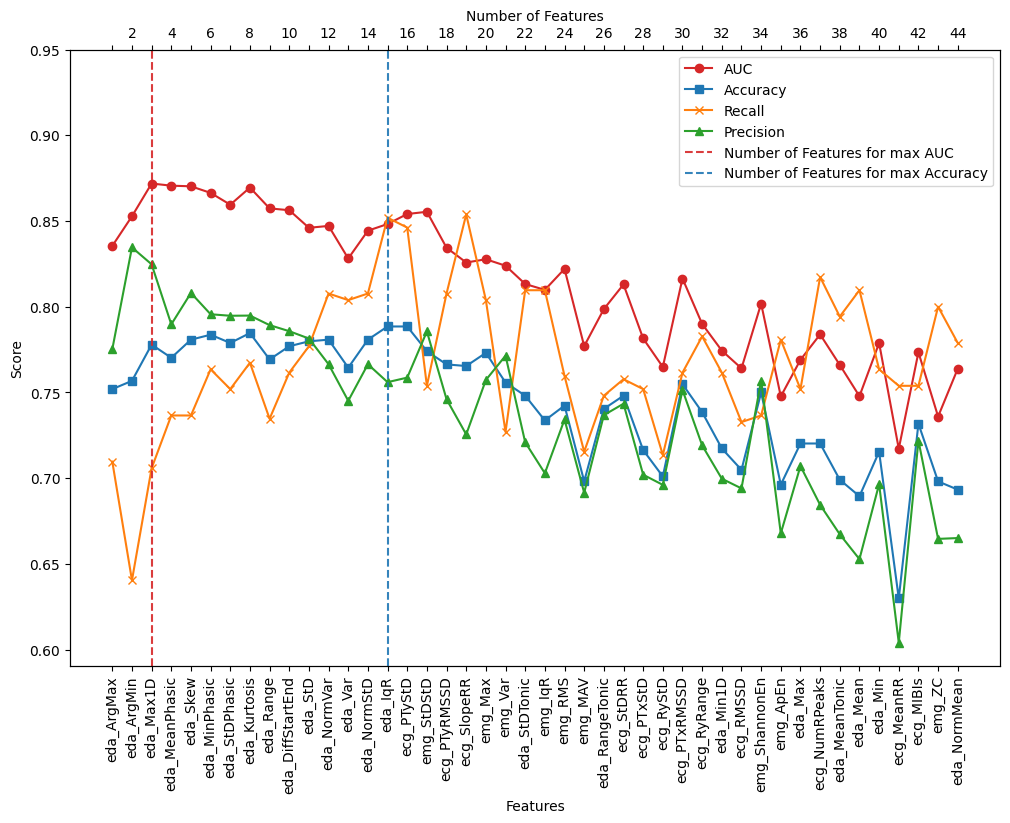

Max AUC: 0.8718694526627219
Max Accuracy: 0.7884615384615384


In [14]:
plot_ranked_feature_selection(features, feature_importance_if, params)

### 3. Rank features using Random Forest

In [5]:
# all features sorted by importance (descending) according to random forest
feature_importance_rf = ['eda_ArgMax', 'eda_DiffStartEnd', 'eda_ArgMin', 'eda_MeanPhasic', 'eda_Max1D', 'eda_MinPhasic', 'eda_Skew', 'eda_Range', 'eda_StDPhasic', 'eda_NormVar','eda_StD', 'eda_Var', 'eda_Kurtosis', 'eda_Min1D', 'eda_NormMean', 'eda_IqR', 'eda_NormStD', 'eda_MeanTonic', 'eda_RangeTonic', 'eda_Min', 'eda_StDTonic', 'eda_Mean', 'ecg_SlopeRR', 'eda_Max', 'emg_StDStD', 'ecg_RMSSD', 'ecg_MeanRR', 'ecg_StDRR', 'ecg_PTyRMSSD', 'emg_MAV', 'ecg_PTyStD', 'emg_IqR', 'emg_ApEn', 'ecg_MIBIs', 'emg_Var', 'emg_Max', 'emg_ZC', 'ecg_RyRange', 'ecg_RyStD', 'emg_RMS', 'ecg_PTxStD', 'emg_ShannonEn', 'ecg_PTxRMSSD', 'ecg_NumRPeaks']

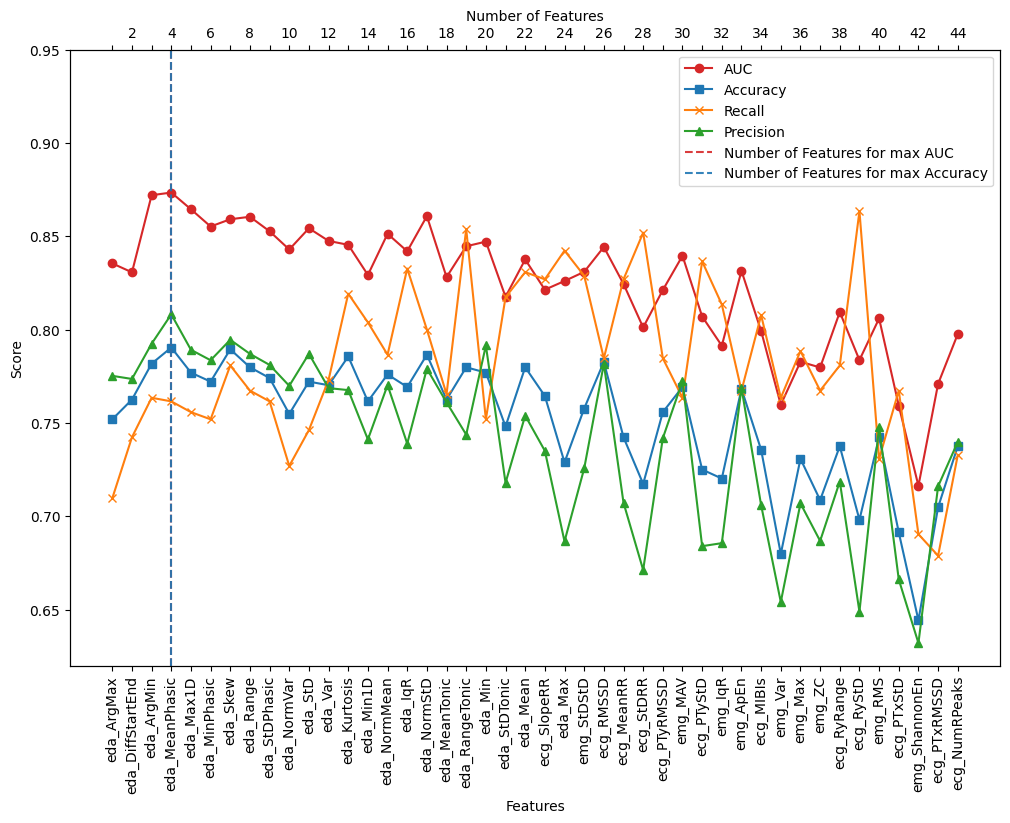

Max AUC: 0.8734134615384614
Max Accuracy: 0.7903846153846154


In [15]:
plot_ranked_feature_selection(features, feature_importance_rf, params)

In [ ]:
from scipy.stats import gaussian_kde

def plot_histogram2(scores_0, scores_1, legend_loc='upper left', y_lim_top=100):

    range = (min(np.concatenate([scores_0, scores_1])), max(np.concatenate([scores_0, scores_1])))

    plt.figure(figsize=(6,5))
    
    counts_0, bins_0, _ = plt.hist(scores_0, bins=80, alpha=0.5, range= range, label='Normal')
    counts_1, bins_1, _ = plt.hist(scores_1, bins=80, alpha=0.5, range= range, label='Anomaly')

    kde_0 = gaussian_kde(scores_0, bw_method=0.1)
    kde_1 = gaussian_kde(scores_1, bw_method=0.1)

    x_vals = np.linspace(range[0], range[1], 500)
    kde_0_vals = kde_0(x_vals) * max(counts_0) / max(kde_0(x_vals))
    kde_1_vals = kde_1(x_vals) * max(counts_1) / max(kde_1(x_vals))

    plt.plot(x_vals, kde_0_vals, color='tab:blue', linewidth=2)
    plt.plot(x_vals, kde_1_vals, color='tab:orange', linewidth=2)


    plt.axvline(x=0, color='black', linestyle='--', label='Threshold')
    plt.xlabel('Anomaly Score', fontsize=14)
    #plt.ylabel('Frequency')
    #plt.ylim(top=y_lim_top)
    plt.yticks([])
    #plt.legend(loc=legend_loc)

    #plt.savefig('if_eda_hist.pdf', format='pdf', bbox_inches='tight')
    plt.show()

## Final Results
(All features considered, only EDA features selected)

In [5]:
top_4_features = ['eda_ArgMax', 'eda_DiffStartEnd', 'eda_ArgMin', 'eda_MeanPhasic']

auc_scores, threshold_scores, scores_normal, scores_anomaly = run_loso_CV(features[top_4_features + ['subject_id', 'class']], params, percentile=84.8)

In [9]:
print_results(auc_scores, threshold_scores)

    AUC: 0.8805 ± 0.1342

default_threshold
    Acc: 0.7649 ± 0.1321
    Prec: 0.8578 ± 0.1644
    Rec: 0.6822 ± 0.2166
    Threshold: 0.5000 ± 0.0000

test_supervised_acc_threshold
    Acc: 0.8670 ± 0.1211
    Prec: 0.8766 ± 0.1248
    Rec: 0.8667 ± 0.1559
    Threshold: 0.5602 ± 0.1040
    Percentile: 81.3218 ± 15.7469

train_supervised_acc_threshold
    Acc: 0.8066 ± 0.1372
    Prec: 0.8217 ± 0.1325
    Rec: 0.7701 ± 0.2568
    Threshold: 0.6068 ± 0.0154

fixed_percentile_threshold
    Acc: 0.8043 ± 0.1402
    Prec: 0.8254 ± 0.1331
    Rec: 0.7586 ± 0.2637
    Threshold: 0.6080 ± 0.0096

mixmod_threshold
    Acc: 0.5000 ± 0.0000
    Prec: 0.5000 ± 0.0000
    Rec: 1.0000 ± 0.0000
    Threshold: 0.1853 ± 0.0427

filter_threshold
    Acc: 0.6520 ± 0.1268
    Prec: 0.6109 ± 0.1097
    Rec: 0.9552 ± 0.0974
    Threshold: 0.3758 ± 0.0155

karch_threshold
    Acc: 0.7917 ± 0.1310
    Prec: 0.7823 ± 0.1333
    Rec: 0.8011 ± 0.2351
    Threshold: 0.5599 ± 0.0210

eb_threshold
    Acc: 0.5046

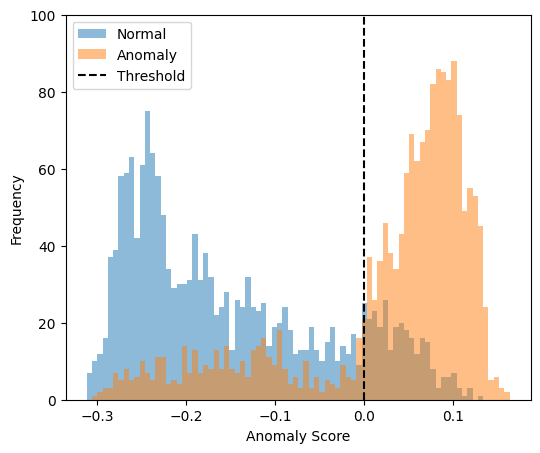

In [26]:
plot_histogram(np.concatenate(scores_normal), np.concatenate(scores_anomaly))

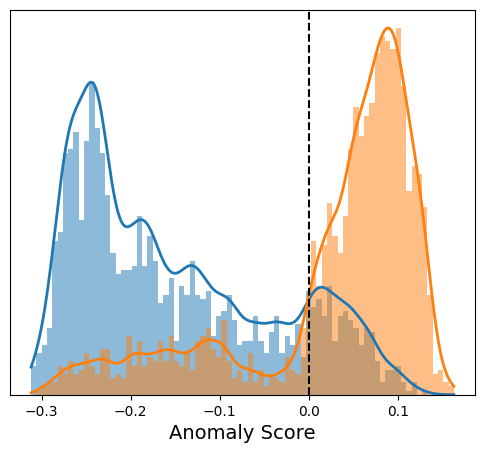

In [ ]:
plot_histogram2(np.concatenate(scores_normal), np.concatenate(scores_anomaly))

### ECG

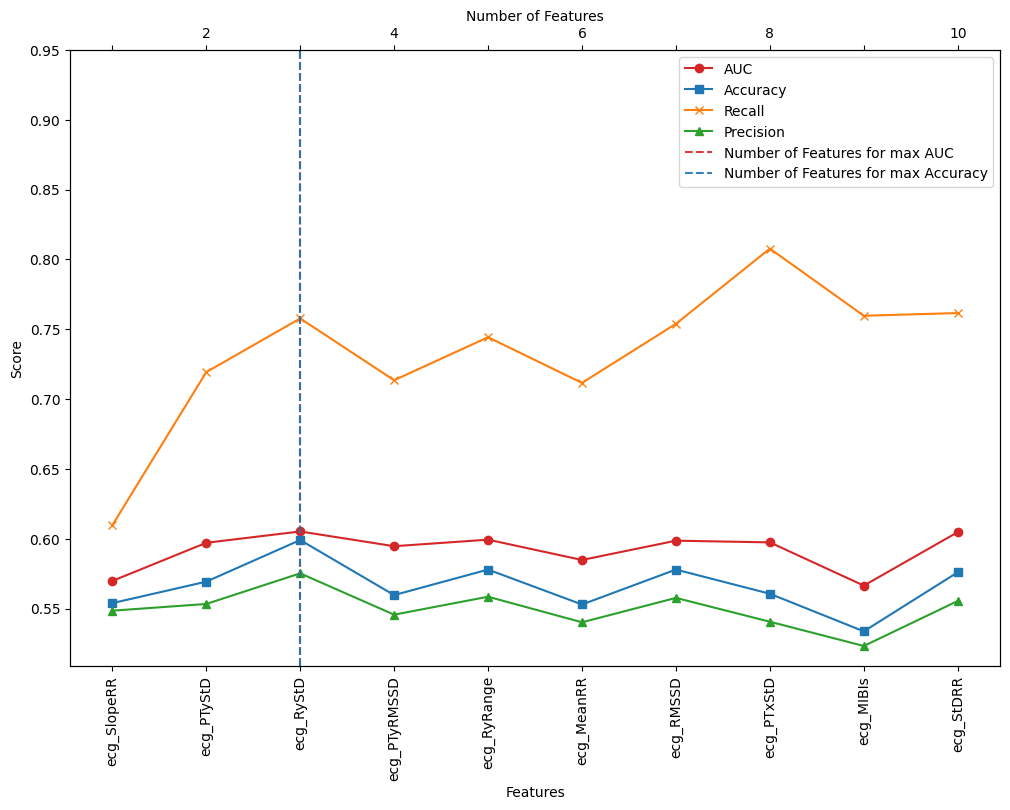

Max AUC: 0.6051701183431952
Max Accuracy: 0.5990384615384615


In [7]:
# ecg features sorted by importance (descending) according to random forest
feature_importance_rf_ecg = ['ecg_SlopeRR', 'ecg_PTyStD', 'ecg_RyStD', 'ecg_PTyRMSSD', 'ecg_RyRange', 'ecg_MeanRR', 'ecg_RMSSD', 'ecg_PTxStD', 'ecg_MIBIs', 'ecg_StDRR']
plot_ranked_feature_selection(features, feature_importance_rf_ecg, params, signal='ecg')

In [12]:
top_3_features_ecg = ['ecg_SlopeRR', 'ecg_PTyStD', 'ecg_RyStD']
auc_scores_ecg, threshold_scores_ecg, scores_normal_ecg, scores_anomaly_ecg = run_loso_CV(features[top_3_features_ecg + ['subject_id', 'class']], params, percentile=64.46)

In [13]:
print_results(auc_scores_ecg, threshold_scores_ecg)

    AUC: 0.6021 ± 0.1646

default_threshold
    Acc: 0.5733 ± 0.1263
    Prec: 0.5771 ± 0.1460
    Rec: 0.7247 ± 0.1944
    Threshold: 0.5000 ± 0.0000

test_supervised_acc_threshold
    Acc: 0.6569 ± 0.1095
    Prec: 0.6729 ± 0.1664
    Rec: 0.6638 ± 0.2578
    Threshold: 0.4760 ± 0.0599
    Percentile: 60.0000 ± 24.8443

train_supervised_acc_threshold
    Acc: 0.5767 ± 0.1279
    Prec: 0.5603 ± 0.1928
    Rec: 0.5144 ± 0.2920
    Threshold: 0.4779 ± 0.0120

fixed_percentile_threshold
    Acc: 0.5859 ± 0.1290
    Prec: 0.5618 ± 0.2006
    Rec: 0.5241 ± 0.2945
    Threshold: 0.4784 ± 0.0072

mixmod_threshold
    Acc: 0.5319 ± 0.0711
    Prec: 0.5209 ± 0.0931
    Rec: 0.8253 ± 0.2635
    Threshold: 0.4108 ± 0.0537

filter_threshold
    Acc: 0.5000 ± 0.0000
    Prec: 0.5000 ± 0.0000
    Rec: 1.0000 ± 0.0000
    Threshold: 0.3363 ± 0.0162

karch_threshold
    Acc: 0.5606 ± 0.0990
    Prec: 0.5377 ± 0.1163
    Rec: 0.6718 ± 0.2726
    Threshold: 0.4491 ± 0.0211

eb_threshold
    Acc: 0.5000

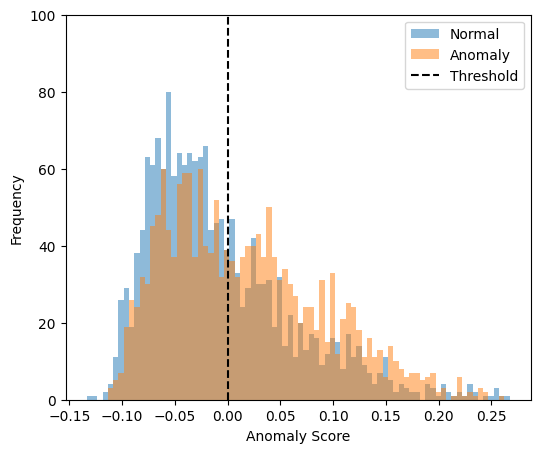

In [15]:
plot_histogram(np.concatenate(scores_normal_ecg), np.concatenate(scores_anomaly_ecg), legend_loc='upper right')

### EMG

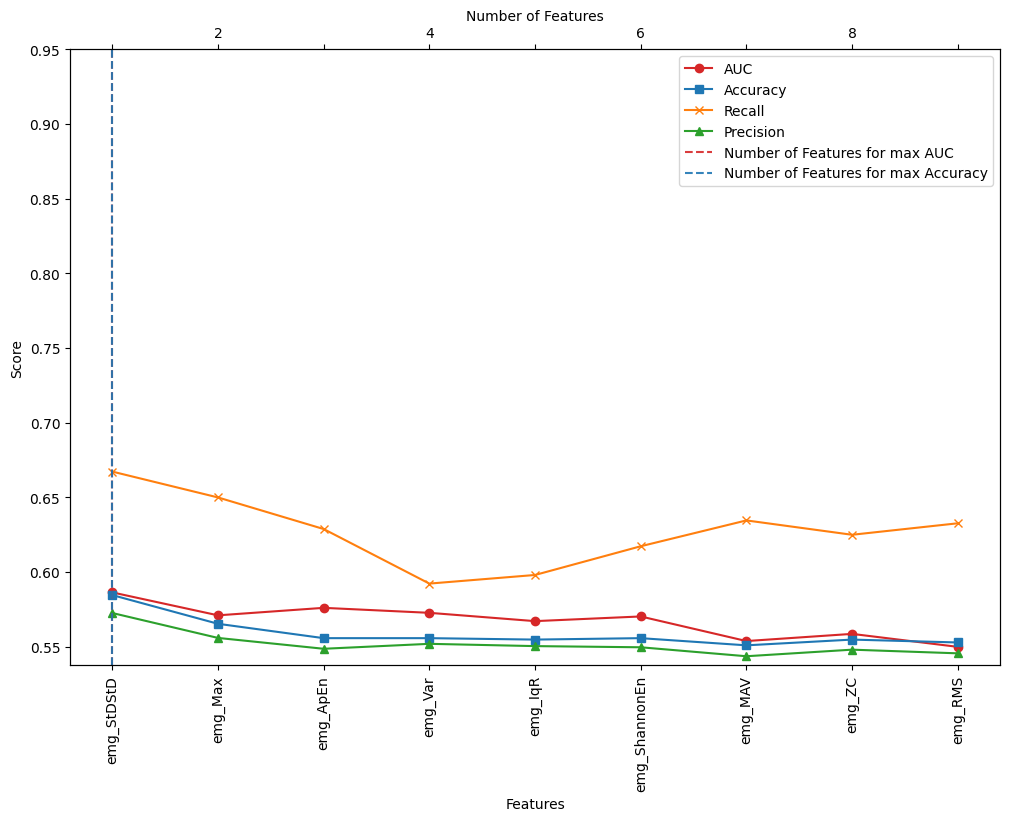

Max AUC: 0.5864034763313609
Max Accuracy: 0.5846153846153846


In [8]:
# emg features sorted by importance (descending) according to random forest
feature_importance_rf_emg = ['emg_StDStD', 'emg_Max', 'emg_ApEn', 'emg_Var', 'emg_IqR', 'emg_ShannonEn','emg_MAV','emg_ZC', 'emg_RMS']
plot_ranked_feature_selection(features, feature_importance_rf_emg, params, signal='emg')

In [ ]:
top_1_features_emg = ['emg_StDStD']
auc_scores_emg, threshold_scores_emg, scores_normal_emg, scores_anomaly_emg = run_loso_CV(features[top_1_features_emg + ['subject_id', 'class']], params, percentile=84.29)

In [15]:
print_results(auc_scores_emg, threshold_scores_emg)

    AUC: 0.6053 ± 0.1828

default_threshold
    Acc: 0.5569 ± 0.1121
    Prec: 0.5515 ± 0.2422
    Rec: 0.6425 ± 0.3502
    Threshold: 0.5000 ± 0.0000

test_supervised_acc_threshold
    Acc: 0.6638 ± 0.1263
    Prec: 0.7031 ± 0.2233
    Rec: 0.5925 ± 0.2901
    Threshold: 0.5082 ± 0.0920
    Percentile: 64.7701 ± 28.0282

train_supervised_acc_threshold
    Acc: 0.5767 ± 0.1270
    Prec: 0.5241 ± 0.3766
    Rec: 0.3144 ± 0.3469
    Threshold: 0.5834 ± 0.0161

fixed_percentile_threshold
    Acc: 0.5779 ± 0.1274
    Prec: 0.5218 ± 0.3819
    Rec: 0.3149 ± 0.3485
    Threshold: 0.5872 ± 0.0144

mixmod_threshold
    Acc: 0.5020 ± 0.0201
    Prec: 0.5031 ± 0.0290
    Rec: 0.9908 ± 0.0575
    Threshold: 0.2367 ± 0.0891

filter_threshold
    Acc: 0.5000 ± 0.0000
    Prec: 0.5000 ± 0.0000
    Rec: 1.0000 ± 0.0000
    Threshold: 0.3211 ± 0.0170

karch_threshold
    Acc: 0.5598 ± 0.1210
    Prec: 0.5238 ± 0.2659
    Rec: 0.5075 ± 0.3777
    Threshold: 0.4873 ± 0.0214

eb_threshold
    Acc: 0.5000

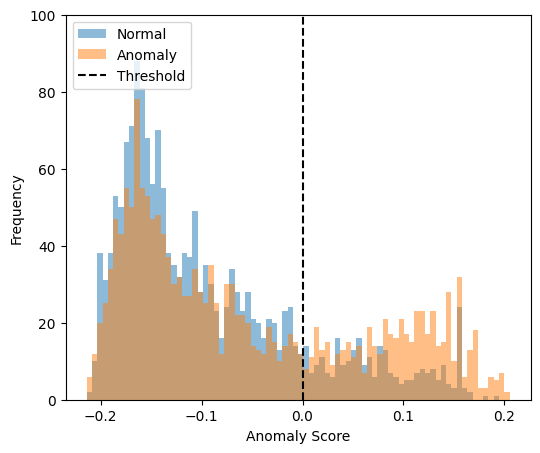

In [20]:
plot_histogram(np.concatenate(scores_normal_emg), np.concatenate(scores_anomaly_emg))

## Single Feature
Direct Thresholding on a single feature as a baseline.
### eda_ArgMax

In [ ]:
auc_scores_eda_ArgMax, threshold_scores_eda_ArgMax, scores_normal_eda_ArgMax, scores_anomaly_eda_ArgMax = run_loso_CV(features[['eda_ArgMax'] + ['subject_id', 'class']], {}, percentile=89.7, direct_thresholding=True)

print_results(auc_scores_eda_ArgMax, threshold_scores_eda_ArgMax, i=1)

    AUC: 0.8418 ± 0.1442

test_supervised_acc_threshold
    Acc: 0.8494 ± 0.1289
    Prec: 0.8930 ± 0.1361
    Rec: 0.7810 ± 0.2417
    Threshold: 0.5529 ± 0.3123
    Percentile: 77.4713 ± 27.4058

train_supervised_acc_threshold
    Acc: 0.8264 ± 0.1367
    Prec: 0.8687 ± 0.1215
    Rec: 0.7563 ± 0.2531
    Threshold: 0.6996 ± 0.0032

fixed_percentile_threshold
    Acc: 0.8261 ± 0.1375
    Prec: 0.8679 ± 0.1222
    Rec: 0.7563 ± 0.2549
    Threshold: 0.7023 ± 0.0077

mixmod_threshold
    Acc: 0.7954 ± 0.1479
    Prec: 0.9094 ± 0.1431
    Rec: 0.6408 ± 0.2887
    Threshold: 0.9998 ± 0.0000

filter_threshold
    Acc: 0.7968 ± 0.1303
    Prec: 0.7915 ± 0.1210
    Rec: 0.8000 ± 0.2324
    Threshold: 0.2594 ± 0.0049

karch_threshold
    Acc: 0.8078 ± 0.1339
    Prec: 0.8126 ± 0.1197
    Rec: 0.7874 ± 0.2399
    Threshold: 0.4003 ± 0.0016

eb_threshold
    Acc: 0.8020 ± 0.1321
    Prec: 0.7998 ± 0.1198
    Rec: 0.7948 ± 0.2365
    Threshold: 0.3285 ± 0.0000



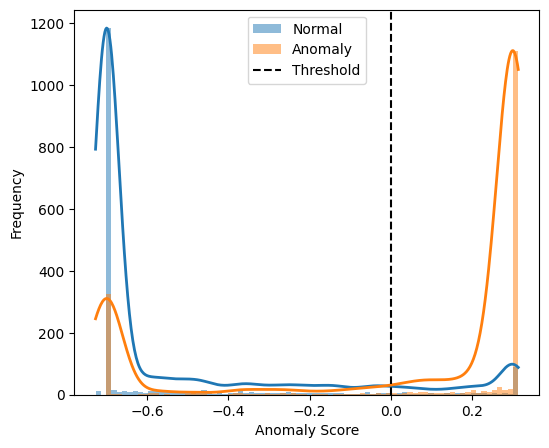

In [17]:
plot_histogram(np.concatenate(scores_normal_eda_ArgMax), np.concatenate(scores_anomaly_eda_ArgMax), y_lim_top=None, legend_loc='upper center')

### eda_DiffStartEnd

In [ ]:
auc_scores_eda_DiffStartEnd, threshold_scores_eda_DiffStartEnd, scores_normal_eda_DiffStartEnd, scores_anomaly_eda_DiffStartEnd = run_loso_CV(features[['eda_DiffStartEnd'] + ['subject_id', 'class']], {}, percentile=80, direct_thresholding=True)

print_results(auc_scores_eda_DiffStartEnd, threshold_scores_eda_DiffStartEnd, i=1)

    AUC: 0.8728 ± 0.1460

test_supervised_acc_threshold
    Acc: 0.8693 ± 0.1271
    Prec: 0.8770 ± 0.1333
    Rec: 0.8810 ± 0.1500
    Threshold: 0.5158 ± 0.0522
    Percentile: 80.0000 ± 19.3723

train_supervised_acc_threshold
    Acc: 0.8109 ± 0.1423
    Prec: 0.8041 ± 0.1481
    Rec: 0.8178 ± 0.2147
    Threshold: 0.5012 ± 0.0110

fixed_percentile_threshold
    Acc: 0.8164 ± 0.1360
    Prec: 0.8097 ± 0.1371
    Rec: 0.8339 ± 0.1901
    Threshold: 0.5012 ± 0.0110

mixmod_threshold
    Acc: 0.7121 ± 0.1863
    Prec: 0.7142 ± 0.4194
    Rec: 0.4494 ± 0.3883
    Threshold: 0.5494 ± 0.0118

filter_threshold
    Acc: 0.7888 ± 0.1665
    Prec: 0.8368 ± 0.2405
    Rec: 0.6569 ± 0.3479
    Threshold: 0.5104 ± 0.0108

karch_threshold
    Acc: 0.7408 ± 0.1863
    Prec: 0.7873 ± 0.3647
    Rec: 0.5190 ± 0.3894
    Threshold: 0.5319 ± 0.0109

eb_threshold
    Acc: 0.5046 ± 0.0159
    Prec: 0.5024 ± 0.0086
    Rec: 1.0000 ± 0.0000
    Threshold: 0.3285 ± 0.0018



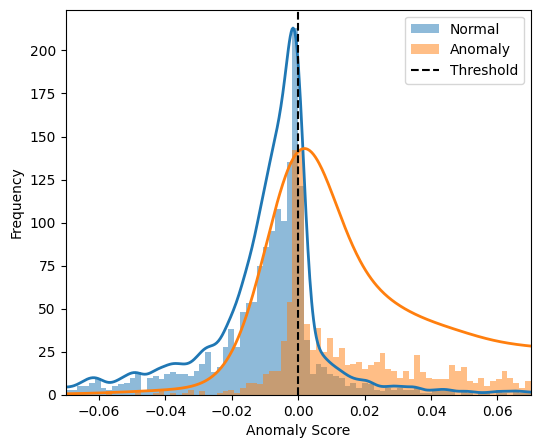

In [42]:
plot_histogram(np.concatenate(scores_normal_eda_DiffStartEnd), np.concatenate(scores_anomaly_eda_DiffStartEnd), y_lim_top=None, legend_loc='upper right', x_lim=(-0.07, 0.07))

# Experiment 2: Subject-Specific Modeling
The Isolation Forest model was trained and evaluated on data from the same subject. For each subject, the model was trained in a 4-fold cross-validation (15 normal training samples, 5 normal test samples and 5 anomalous test samples per fold).

In [20]:
param_grid = {
        'bootstrap': [False],
        'contamination': [0.5, 0.4, 0.3],
        'max_features': [0.5, 0.6, 0.7, 0.8],
        'max_samples': [0.4, 0.5, 0.6],
        'n_estimators': [100, 120, 180],
        }

tfrf = ['eda_ArgMax', 'eda_ArgMin', 'eda_DiffStartEnd', 'eda_MeanPhasic', 'eda_Max1D','eda_NormMean', 'eda_MinPhasic','eda_Range', 'eda_Var']

#grid_search(features[tfrf + ['subject_id', 'class']], param_grid, subject_specific=True)

# Isolation Forest parameters
params_2 = {'bootstrap': False, 'contamination': 0.5, 'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 120}

## Feature Selection
Rank features using Random Forest

In [21]:
# all features sorted by importance (descending) according to random forest
feature_importance_rf = ['eda_ArgMax', 'eda_DiffStartEnd', 'eda_ArgMin', 'eda_MeanPhasic', 'eda_Max1D', 'eda_MinPhasic', 'eda_Skew', 'eda_Range', 'eda_StDPhasic', 'eda_NormVar',
'eda_StD', 'eda_Var', 'eda_Kurtosis', 'eda_Min1D', 'eda_NormMean', 'eda_IqR',
'eda_NormStD', 'eda_MeanTonic', 'eda_RangeTonic', 'eda_Min', 'eda_StDTonic',
'eda_Mean', 'ecg_SlopeRR', 'eda_Max', 'emg_StDStD', 'ecg_RMSSD', 'ecg_MeanRR',
'ecg_StDRR', 'ecg_PTyRMSSD', 'emg_MAV', 'ecg_PTyStD', 'emg_IqR', 'emg_ApEn',
'ecg_MIBIs', 'emg_Var', 'emg_Max', 'emg_ZC', 'ecg_RyRange', 'ecg_RyStD',
'emg_RMS', 'ecg_PTxStD', 'emg_ShannonEn', 'ecg_PTxRMSSD', 'ecg_NumRPeaks']

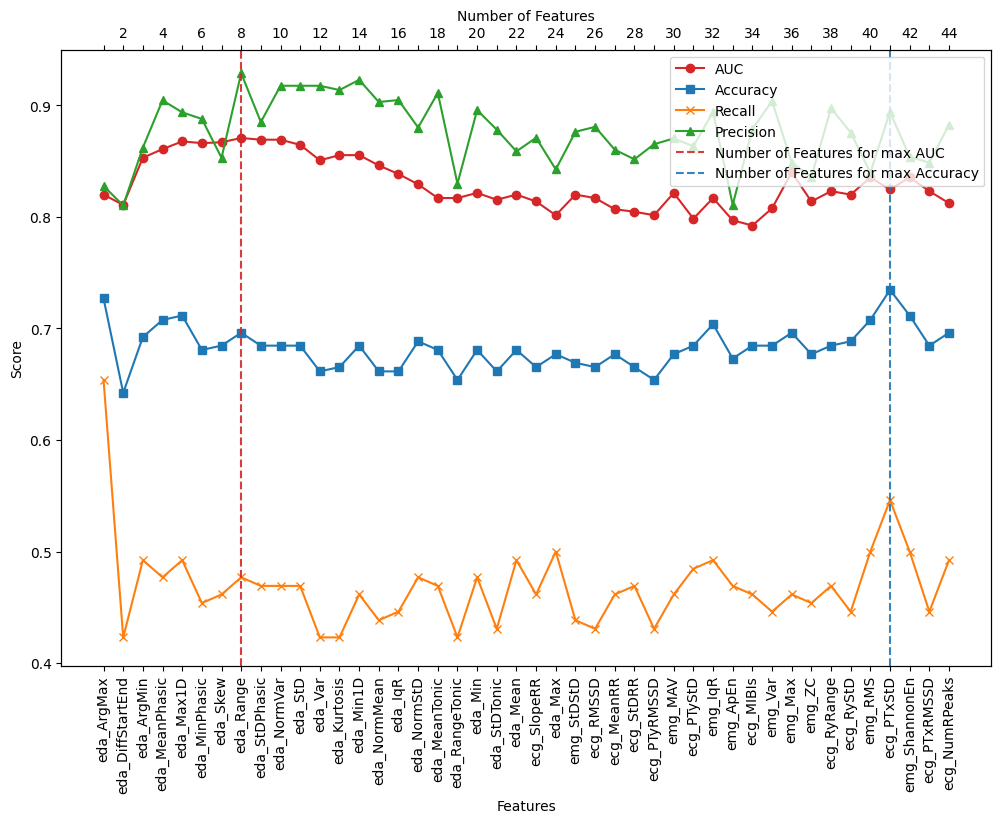

Max AUC: 0.870769230769231
Max Accuracy: 0.7346153846153847


In [ ]:
plot_ranked_feature_selection(features, feature_importance_rf, params_2, subject_specific=True)

## Final Results
(All features considered, only EDA features selected)

In [ ]:
top_8_features = ['eda_ArgMax', 'eda_DiffStartEnd', 'eda_ArgMin', 'eda_MeanPhasic', 'eda_Max1D', 'eda_MinPhasic', 'eda_Skew', 'eda_Range']

auc_scores, threshold_scores, scores_normal, scores_anomaly = run_subject_specific_cv(features[top_8_features + ['subject_id', 'class']], params_2, percentile=84.4)

print_results(auc_scores, threshold_scores)

    AUC: 0.8678 ± 0.1806

default_threshold
    Acc: 0.6885 ± 0.1442
    Prec: 0.8294 ± 0.3058
    Rec: 0.4655 ± 0.2566
    Threshold: 0.4634 ± 0.0182

test_supervised_acc_threshold
    Acc: 0.8891 ± 0.1328
    Prec: 0.9031 ± 0.1621
    Rec: 0.8822 ± 0.2112
    Threshold: 0.5284 ± 0.0580
    Percentile: 69.3103 ± 17.6357

train_supervised_acc_threshold
    Acc: 0.8020 ± 0.1787
    Prec: 0.8087 ± 0.1918
    Rec: 0.8345 ± 0.2284
    Threshold: 0.5455 ± 0.0555

fixed_percentile_threshold
    Acc: 0.7876 ± 0.1685
    Prec: 0.7951 ± 0.2226
    Rec: 0.7598 ± 0.2986
    Threshold: 0.5470 ± 0.0214

mixmod_threshold
    Acc: 0.5385 ± 0.1107
    Prec: 0.5261 ± 0.1390
    Rec: 0.9540 ± 0.1812
    Threshold: 0.3212 ± 0.1318

filter_threshold
    Acc: 0.6006 ± 0.1633
    Prec: 0.3021 ± 0.4148
    Rec: 0.2695 ± 0.3998
    Threshold: 0.7033 ± 0.1443

karch_threshold
    Acc: 0.7293 ± 0.1877
    Prec: 0.6577 ± 0.3466
    Rec: 0.6621 ± 0.3878
    Threshold: 0.5518 ± 0.0549

eb_threshold
    Acc: 0.5506

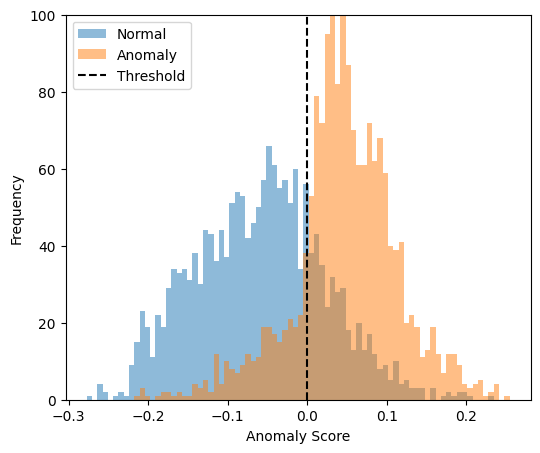

In [9]:
plot_histogram(np.concatenate(scores_normal), np.concatenate(scores_anomaly))

### ECG

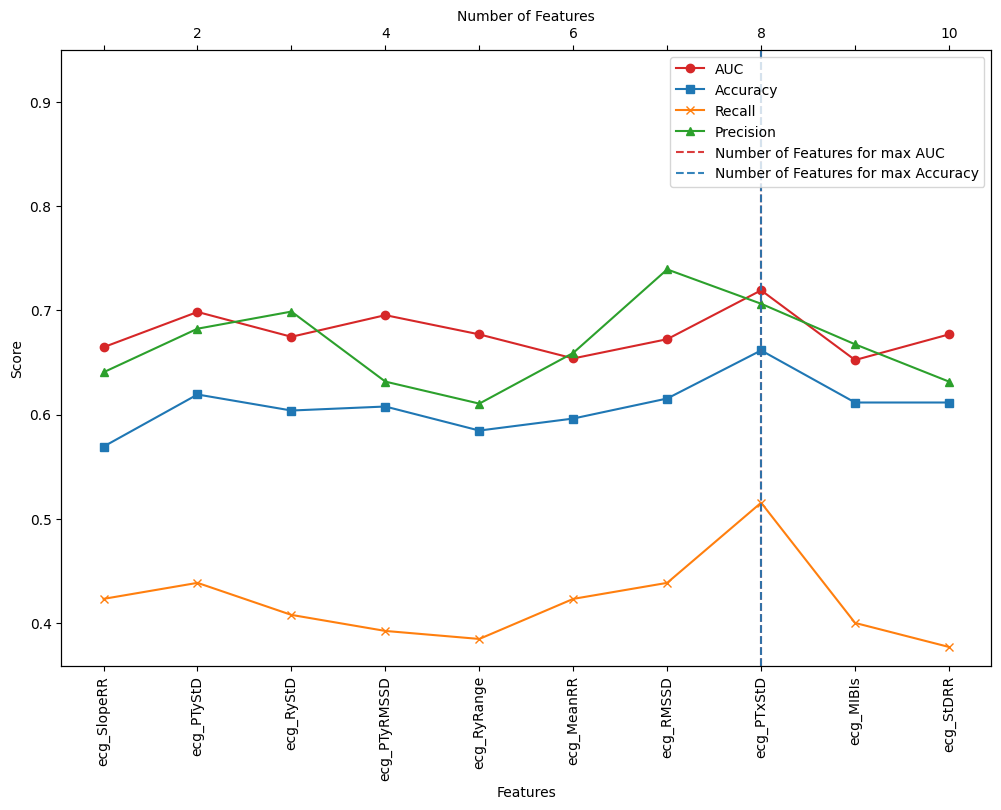

Max AUC: 0.7192307692307693
Max Accuracy: 0.6615384615384616


In [ ]:
# ecg features sorted by importance (descending) according to random forest
feature_importance_rf_ecg = ['ecg_SlopeRR', 'ecg_PTyStD', 'ecg_RyStD', 'ecg_PTyRMSSD', 'ecg_RyRange', 'ecg_MeanRR', 'ecg_RMSSD', 'ecg_PTxStD', 'ecg_MIBIs', 'ecg_StDRR']
plot_ranked_feature_selection(features, feature_importance_rf_ecg, params_2, signal='ecg', subject_specific=True)

In [ ]:
top_8_features_ecg = ['ecg_SlopeRR', 'ecg_PTyStD', 'ecg_RyStD', 'ecg_PTyRMSSD', 'ecg_RyRange', 'ecg_MeanRR', 'ecg_RMSSD', 'ecg_PTxStD']

auc_scores_ecg, threshold_scores_ecg, scores_normal_ecg, scores_anomaly_ecg = run_subject_specific_cv(features[top_8_features_ecg + ['subject_id', 'class']], params_2, percentile=63.2)

print_results(auc_scores_ecg, threshold_scores_ecg)

    AUC: 0.6332 ± 0.2326

default_threshold
    Acc: 0.5802 ± 0.1678
    Prec: 0.6280 ± 0.3281
    Rec: 0.4075 ± 0.2469
    Threshold: 0.4754 ± 0.0122

test_supervised_acc_threshold
    Acc: 0.7356 ± 0.1396
    Prec: 0.7395 ± 0.2343
    Rec: 0.7523 ± 0.2855
    Threshold: 0.4898 ± 0.0330
    Percentile: 51.8966 ± 26.5631

train_supervised_acc_threshold
    Acc: 0.5954 ± 0.1792
    Prec: 0.5916 ± 0.2095
    Rec: 0.7270 ± 0.2714
    Threshold: 0.4840 ± 0.0296

fixed_percentile_threshold
    Acc: 0.5888 ± 0.1741
    Prec: 0.5821 ± 0.2160
    Rec: 0.6253 ± 0.2968
    Threshold: 0.4879 ± 0.0125

mixmod_threshold
    Acc: 0.5170 ± 0.0829
    Prec: 0.4571 ± 0.2261
    Rec: 0.7661 ± 0.3807
    Threshold: 0.4196 ± 0.1204

filter_threshold
    Acc: 0.5095 ± 0.0592
    Prec: 0.1064 ± 0.2557
    Rec: 0.0902 ± 0.2473
    Threshold: 0.6991 ± 0.1451

karch_threshold
    Acc: 0.5310 ± 0.1177
    Prec: 0.2516 ± 0.3489
    Rec: 0.2454 ± 0.3731
    Threshold: 0.5700 ± 0.0790

eb_threshold
    Acc: 0.5040

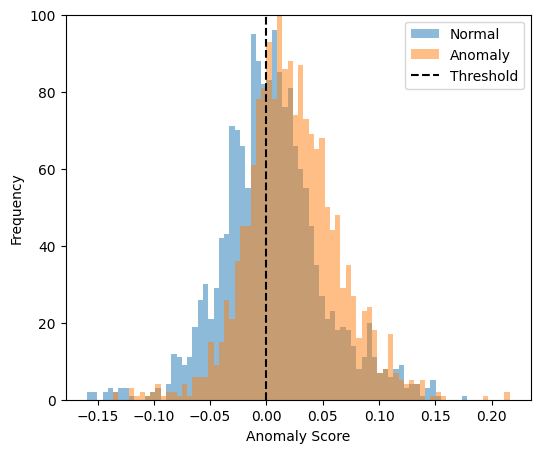

In [16]:
plot_histogram(np.concatenate(scores_normal_ecg), np.concatenate(scores_anomaly_ecg), legend_loc='upper right')

### EMG

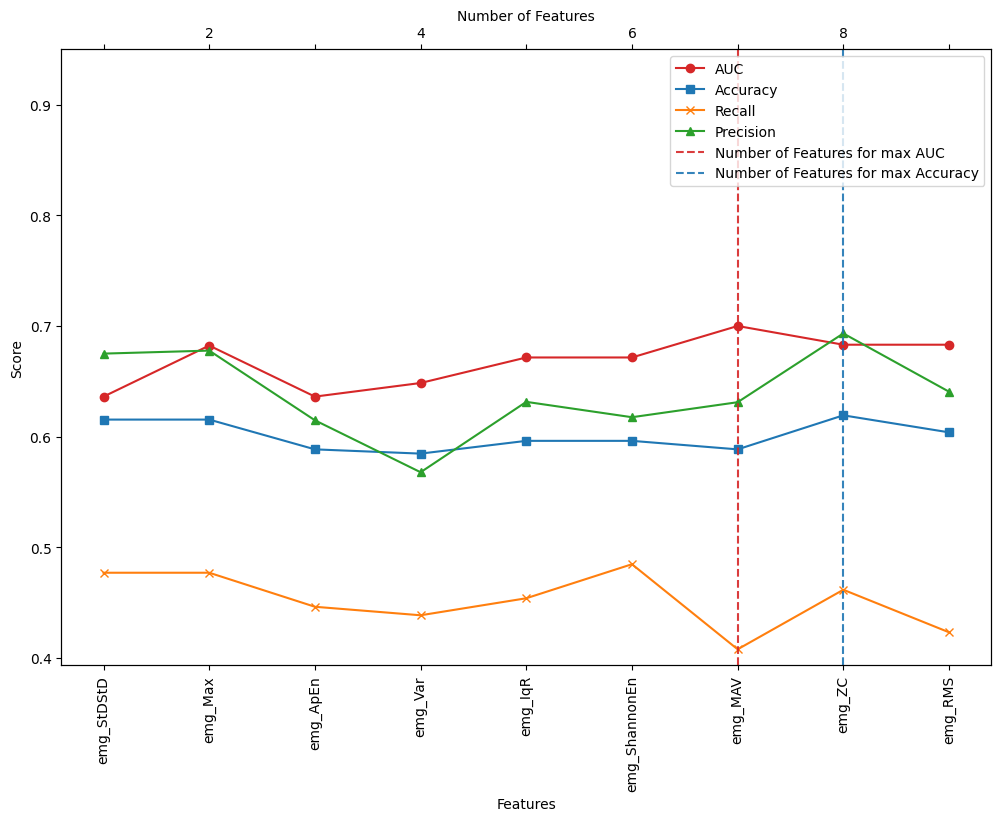

Max AUC: 0.7
Max Accuracy: 0.6192307692307693


In [ ]:
# emg features sorted by importance (descending) according to random forest
feature_importance_rf_emg = ['emg_StDStD', 'emg_Max', 'emg_ApEn', 'emg_Var', 'emg_IqR', 'emg_ShannonEn','emg_MAV','emg_ZC', 'emg_RMS']
plot_ranked_feature_selection(features, feature_importance_rf_emg, params_2, signal='emg', subject_specific=True)

In [ ]:
top_7_features_emg = ['emg_StDStD', 'emg_Max', 'emg_ApEn', 'emg_Var', 'emg_IqR', 'emg_ShannonEn','emg_MAV']
auc_scores_emg, threshold_scores_emg, scores_normal_emg, scores_anomaly_emg = run_subject_specific_cv(features[top_7_features_emg + ['subject_id', 'class']], params_2, percentile=61.5)

print_results(auc_scores_emg, threshold_scores_emg)

    AUC: 0.6167 ± 0.2354

default_threshold
    Acc: 0.5480 ± 0.1711
    Prec: 0.5753 ± 0.3117
    Rec: 0.4075 ± 0.2534
    Threshold: 0.4755 ± 0.0184

test_supervised_acc_threshold
    Acc: 0.7239 ± 0.1440
    Prec: 0.7362 ± 0.2721
    Rec: 0.6753 ± 0.3248
    Threshold: 0.5083 ± 0.0523
    Percentile: 57.1839 ± 24.9621

train_supervised_acc_threshold
    Acc: 0.5963 ± 0.1767
    Prec: 0.5921 ± 0.2185
    Rec: 0.7195 ± 0.2787
    Threshold: 0.4913 ± 0.0470

fixed_percentile_threshold
    Acc: 0.5690 ± 0.1813
    Prec: 0.5513 ± 0.2288
    Rec: 0.5908 ± 0.3042
    Threshold: 0.4915 ± 0.0173

mixmod_threshold
    Acc: 0.5172 ± 0.0809
    Prec: 0.5022 ± 0.1660
    Rec: 0.8655 ± 0.2870
    Threshold: 0.3619 ± 0.1243

filter_threshold
    Acc: 0.5267 ± 0.1056
    Prec: 0.2108 ± 0.3448
    Rec: 0.1828 ± 0.3261
    Threshold: 0.6808 ± 0.1586

karch_threshold
    Acc: 0.5474 ± 0.1399
    Prec: 0.3875 ± 0.3620
    Rec: 0.3759 ± 0.3873
    Threshold: 0.5513 ± 0.0798

eb_threshold
    Acc: 0.5167

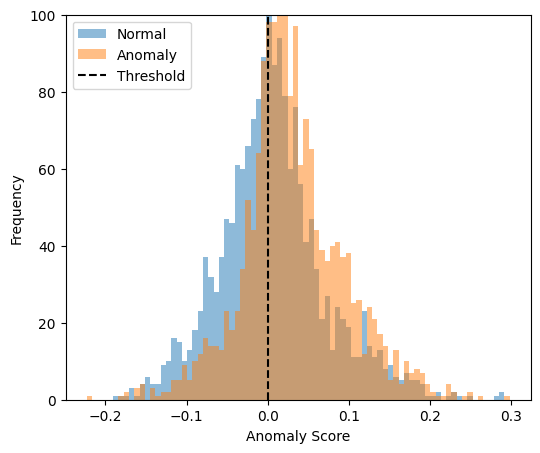

In [21]:
plot_histogram(np.concatenate(scores_normal_emg), np.concatenate(scores_anomaly_emg))